In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from fantasyfootball import nflfastr
from os import path
from fantasyfootball.config import DATA_DIR, pfr_to_fantpros, nfl_color_map, nfl_logo_espn_path_map
import seaborn as sns
import numpy as np
from fantasyfootball.config import FIGURE_DIR
from adjustText import adjust_text
import requests
from io import BytesIO


In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [6]:
year = 2020
df = nflfastr.get_nfl_fast_r_data(2020)

player_df = nflfastr.get_nfl_fast_r_roster_data(2019)

In [7]:
def air_yard_density_transform(df, player_df):
    df = df.copy()
    year = df['game_id'].str.split('_').str[0].max()
    week = df['week'].max() 
    df_cols = ['receiver', 'posteam', 'air_yards']
    play_type = df['play_type'] == 'pass'
    air_yard_threshold = ~df['air_yards'].isna()
    df = df.loc[play_type & air_yard_threshold, df_cols]
    df['total_air_yards'] = df.groupby(['receiver', 'posteam'])['air_yards'].transform('sum')
    df = df.sort_values(['total_air_yards', 'receiver', 'posteam'], ascending=False).drop(columns='total_air_yards').reset_index(drop=True)
    df['colors'] = df['posteam'].map(nfl_color_map)
    df['logo'] = df['posteam'].map(nfl_logo_espn_path_map)
    
    player_df = player_df.loc[player_df['teamPlayers.positionGroup'].isin(['WR', 'RB', 'TE'])].copy()
    player_df['abbrev_name'] = player_df['teamPlayers.firstName'].str[0] + '.' + player_df['teamPlayers.lastName']
    player_df = player_df[['abbrev_name','team.abbr', 'teamPlayers.headshot_url']]
    df = pd.merge(df, player_df, left_on=['posteam', 'receiver'], right_on=['team.abbr', 'abbrev_name'], how='left')
    #df = df.fillna({'teamPlayers.headshot_url': nfl_logo_espn_path_map['NFL']})
    df = (df.drop(columns=['abbrev_name', 'team.abbr'])
            .assign(year=year)
            .assign(week=week)
         )
    return df

In [8]:
df1 = air_yard_density_transform(df, player_df)

In [9]:
df1.head()

,receiver,posteam,air_yards,colors,logo,teamPlayers.headshot_url,year,week
0,C.Ridley,ATL,19.0,#A71930,..\figures\logos\espn\ATL.png,http://static.nfl.com/static/content/public/st...,2020,5
1,C.Ridley,ATL,6.0,#A71930,..\figures\logos\espn\ATL.png,http://static.nfl.com/static/content/public/st...,2020,5
2,C.Ridley,ATL,5.0,#A71930,..\figures\logos\espn\ATL.png,http://static.nfl.com/static/content/public/st...,2020,5
3,C.Ridley,ATL,11.0,#A71930,..\figures\logos\espn\ATL.png,http://static.nfl.com/static/content/public/st...,2020,5
4,C.Ridley,ATL,12.0,#A71930,..\figures\logos\espn\ATL.png,http://static.nfl.com/static/content/public/st...,2020,5


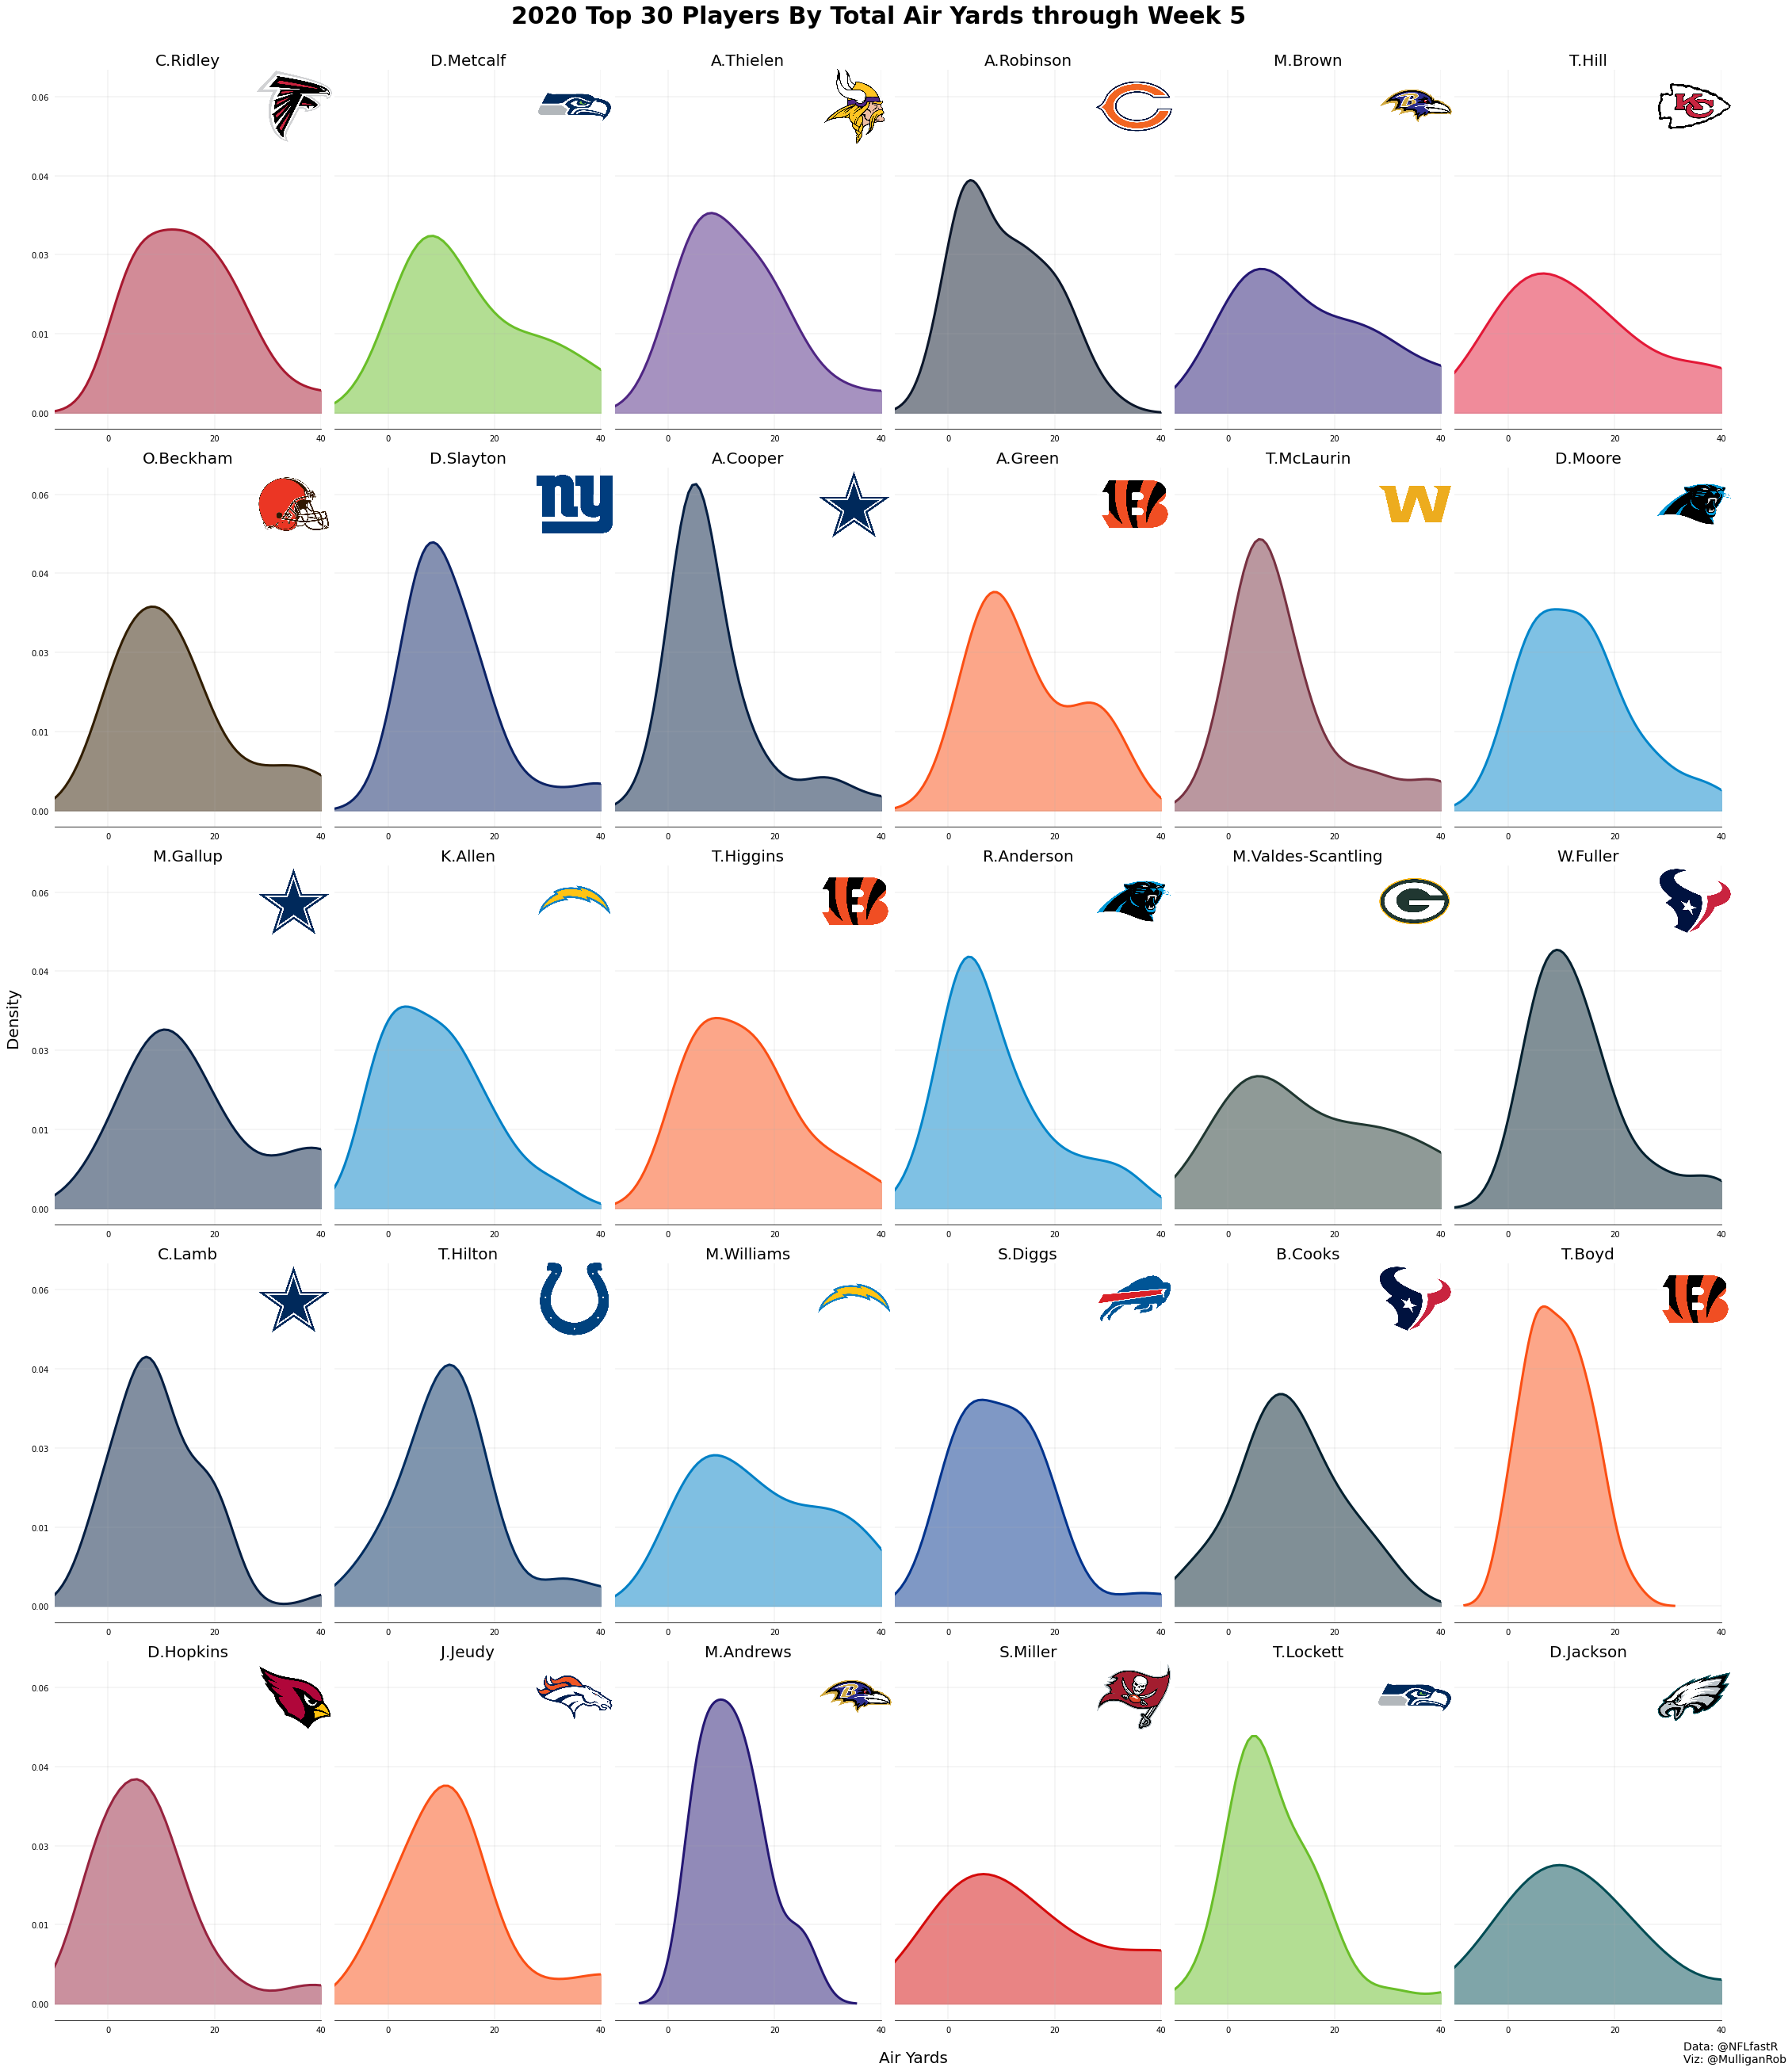

In [10]:
ay_max = 40
ay_min = -10
year = df1['year'].max()
week = df1['week'].max()

#sns.set_style('whitegrid')
fig, axs = plt.subplots(5, 6, sharey=True, figsize=(30,35))
axs_list = [item for sublist in axs for item in sublist] 
axs_list_count = len(axs_list)

ordered_groups = (df1.groupby(['receiver', 'posteam']).sum()
                      .sort_values('air_yards', ascending=False).iloc[:axs_list_count].index
                 )
grouped = df1.groupby(['receiver', 'posteam'])


for group_name in ordered_groups:
    ax = axs_list.pop(0)
    selection = grouped.get_group(group_name)
    player = group_name[0]
    team_color = selection['colors'].max()
    sns.kdeplot(selection['air_yards'], ax=ax, color=team_color, linewidth=3.0)

    #shading
    line = ax.lines[0]
    x = line.get_xydata()[:,0]
    y = line.get_xydata()[:,1]
    ax.fill_between(x, y, color=team_color, alpha=0.5)

    #formatting
    ax.set_title(player, fontsize=20)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(
        which='both',
        bottom=False,
        left=False,
        right=False,
        top=False
    )
    ax.set_xlim((ay_min, ay_max))
    ax.grid(linewidth=0.25)
    ax.get_legend().remove()
    ax.xaxis.set_major_locator(plt.MaxNLocator(3))
    ax.yaxis.set_major_locator(plt.MaxNLocator(6))
    y_labels = ['{:.2f}'.format(x) for x in ax.get_yticks()]
    ax.set_yticklabels(y_labels)

    #team logo
    logo_path = selection['logo'].max()
    image = OffsetImage(plt.imread(logo_path), zoom=.2)
    ax.add_artist(AnnotationBbox(image, xy=(0.9,.9), frameon=False, xycoords='axes fraction'))
    
    """
    #headshot logo
    headshot_url = selection['teamPlayers.headshot_url'].max()
    if pd.isna(headshot_url):
        hs_path = nfl_logo_espn_path_map['NFL']
        hs_image = OffsetImage(plt.imread(hs_path), zoom=.5)
        ax.add_artist(AnnotationBbox(hs_image, xy=(0.1,0.9), frameon=False, xycoords='axes fraction'))
    else:
        response = requests.get(headshot_url)
        hs_image_bytes = plt.imread(BytesIO(response.content))
        hs_image = OffsetImage(hs_image_bytes, zoom=.5)
        ax.add_artist(AnnotationBbox(hs_image, xy=(0.1,0.9), frameon=False, xycoords='axes fraction'))
     """       
for ax in axs_list:
    ax.remove()

#labels and footnotes
fig.suptitle(f'{year} Top {axs_list_count} Players By Total Air Yards through Week {week}', fontsize=30, fontweight='bold', y=1.02)
plt.figtext(0.97, -0.01, 'Data: @NFLfastR\nViz: @MulliganRob', fontsize=14)
plt.figtext(0.5, -0.01, 'Air Yards', fontsize=20)
plt.figtext(-0.01, 0.5, 'Density', fontsize=20, rotation='vertical')


fig.tight_layout()

fig.savefig(r'C:\Users\rmull\smallmult.png', bbox_inches='tight')
            


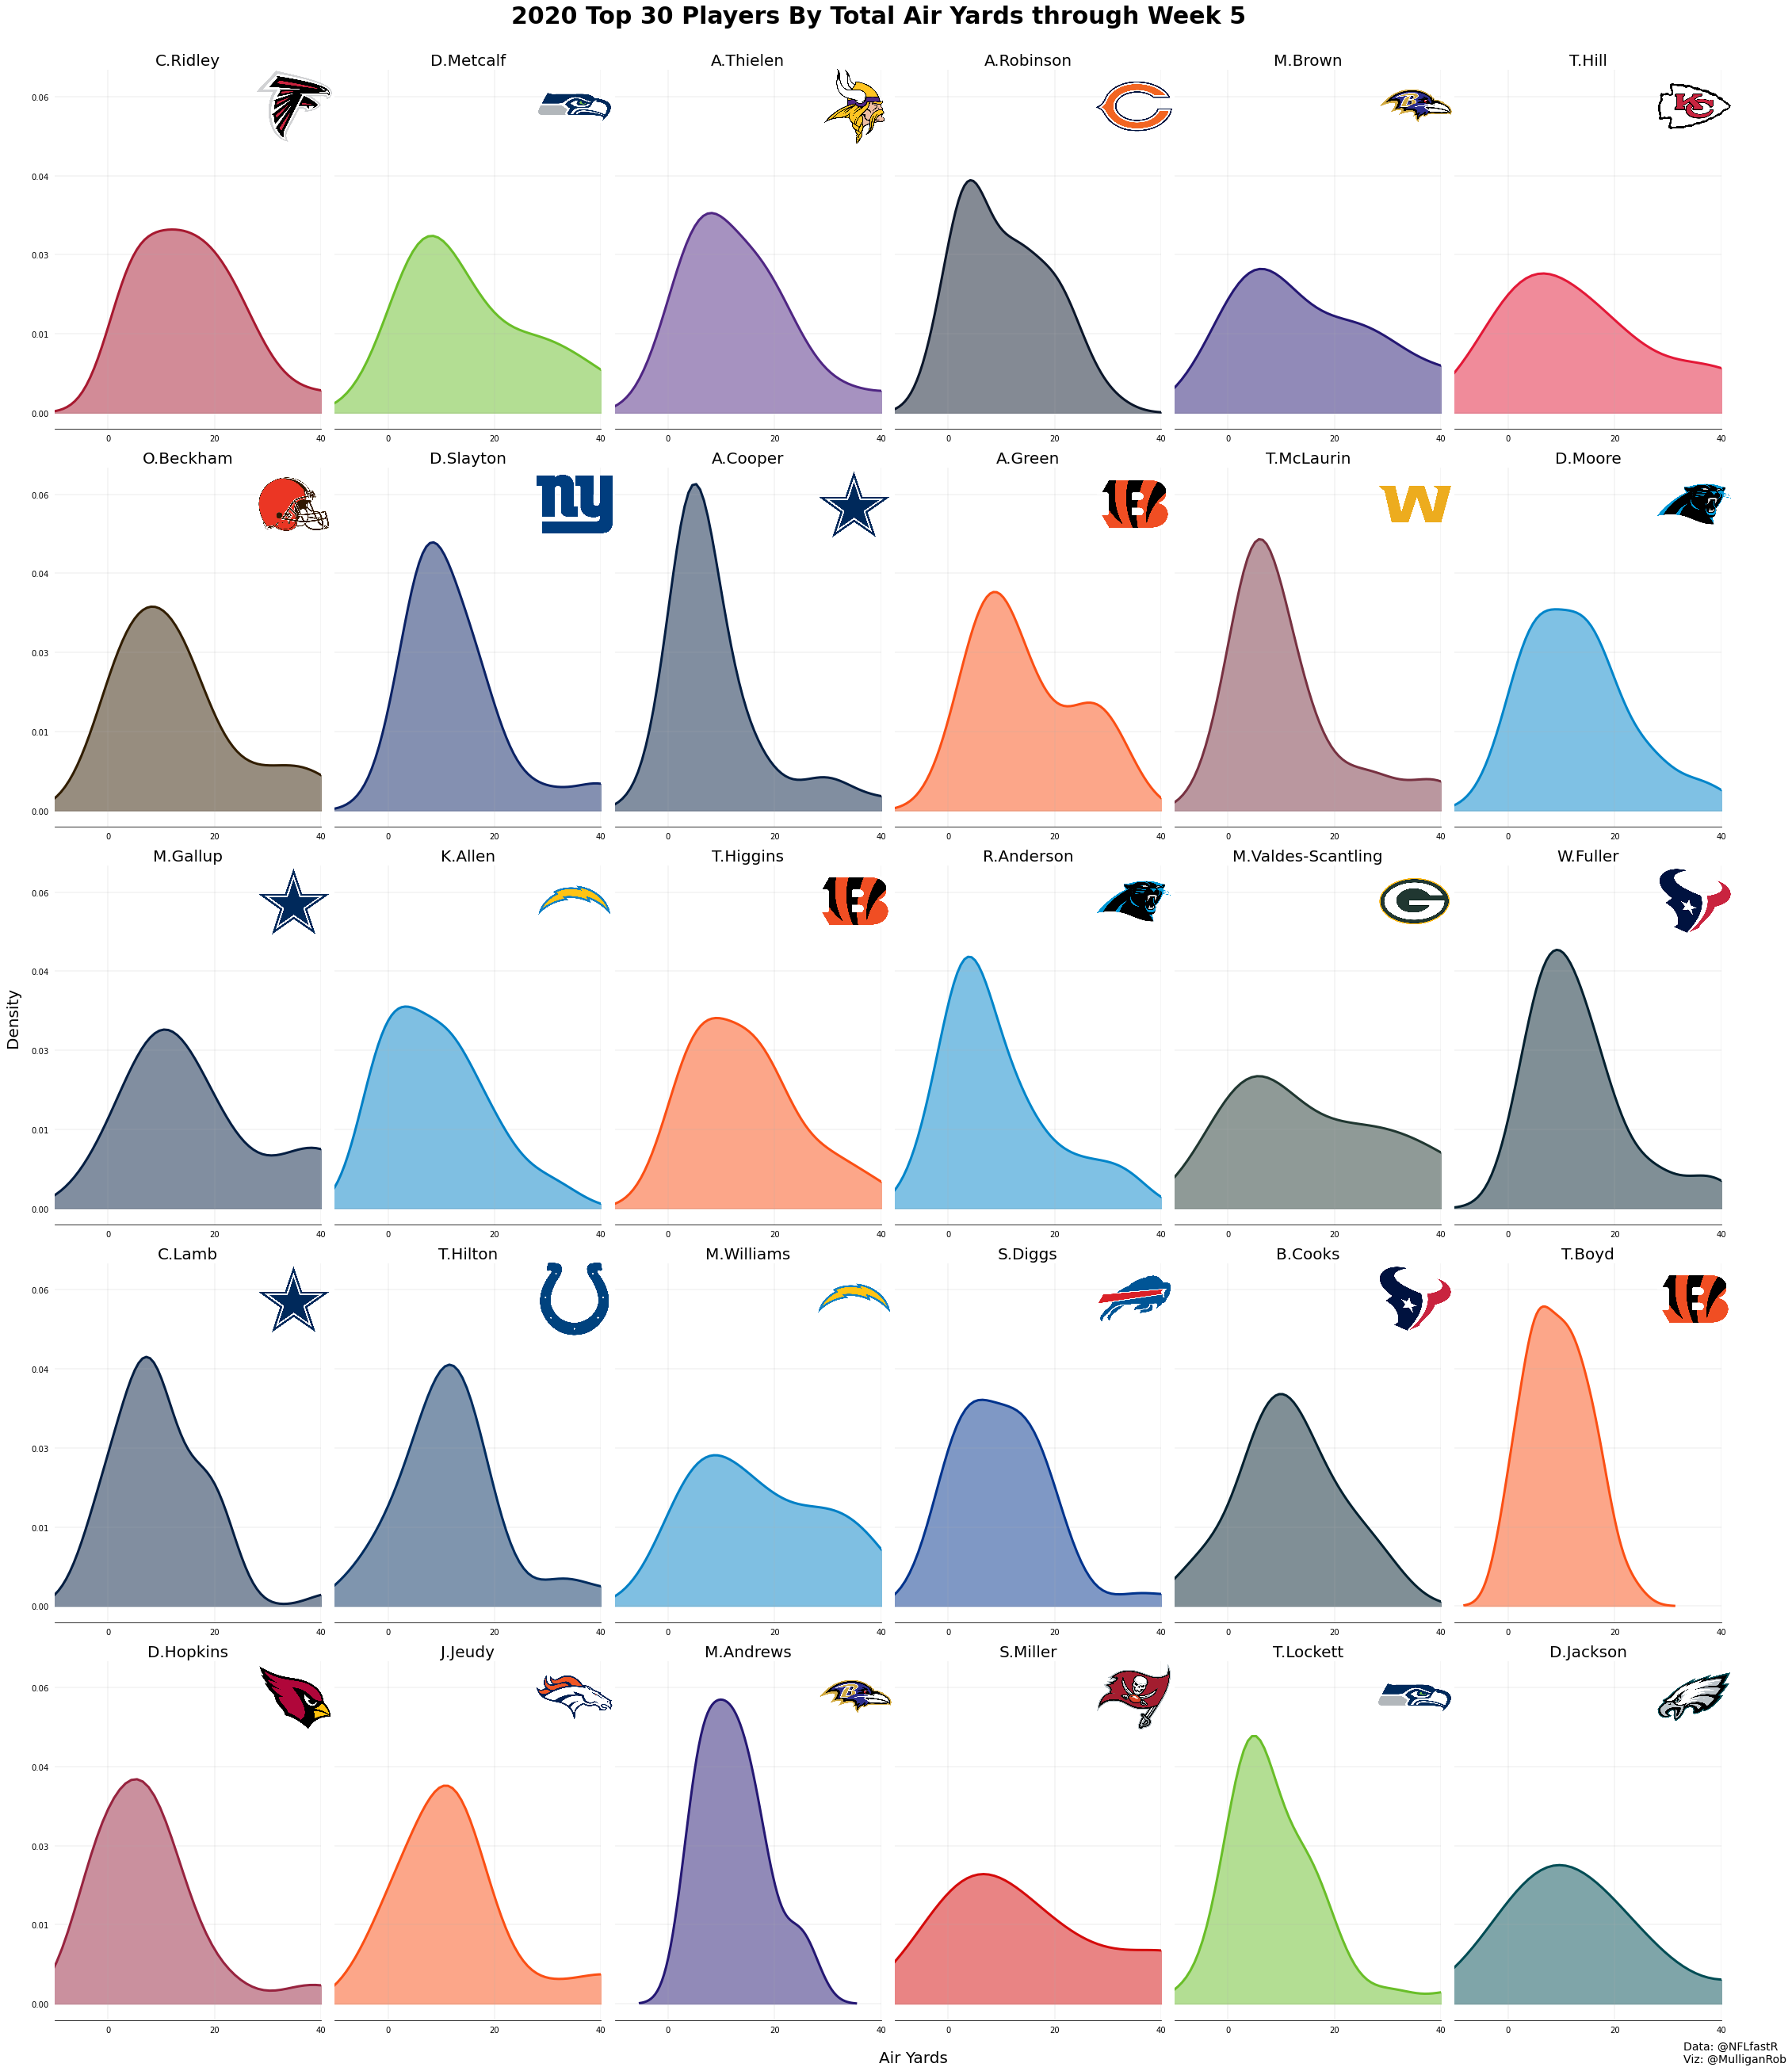

In [19]:
#refactored in nflfastr.py
nflfastr.air_yard_density_viz(df1)

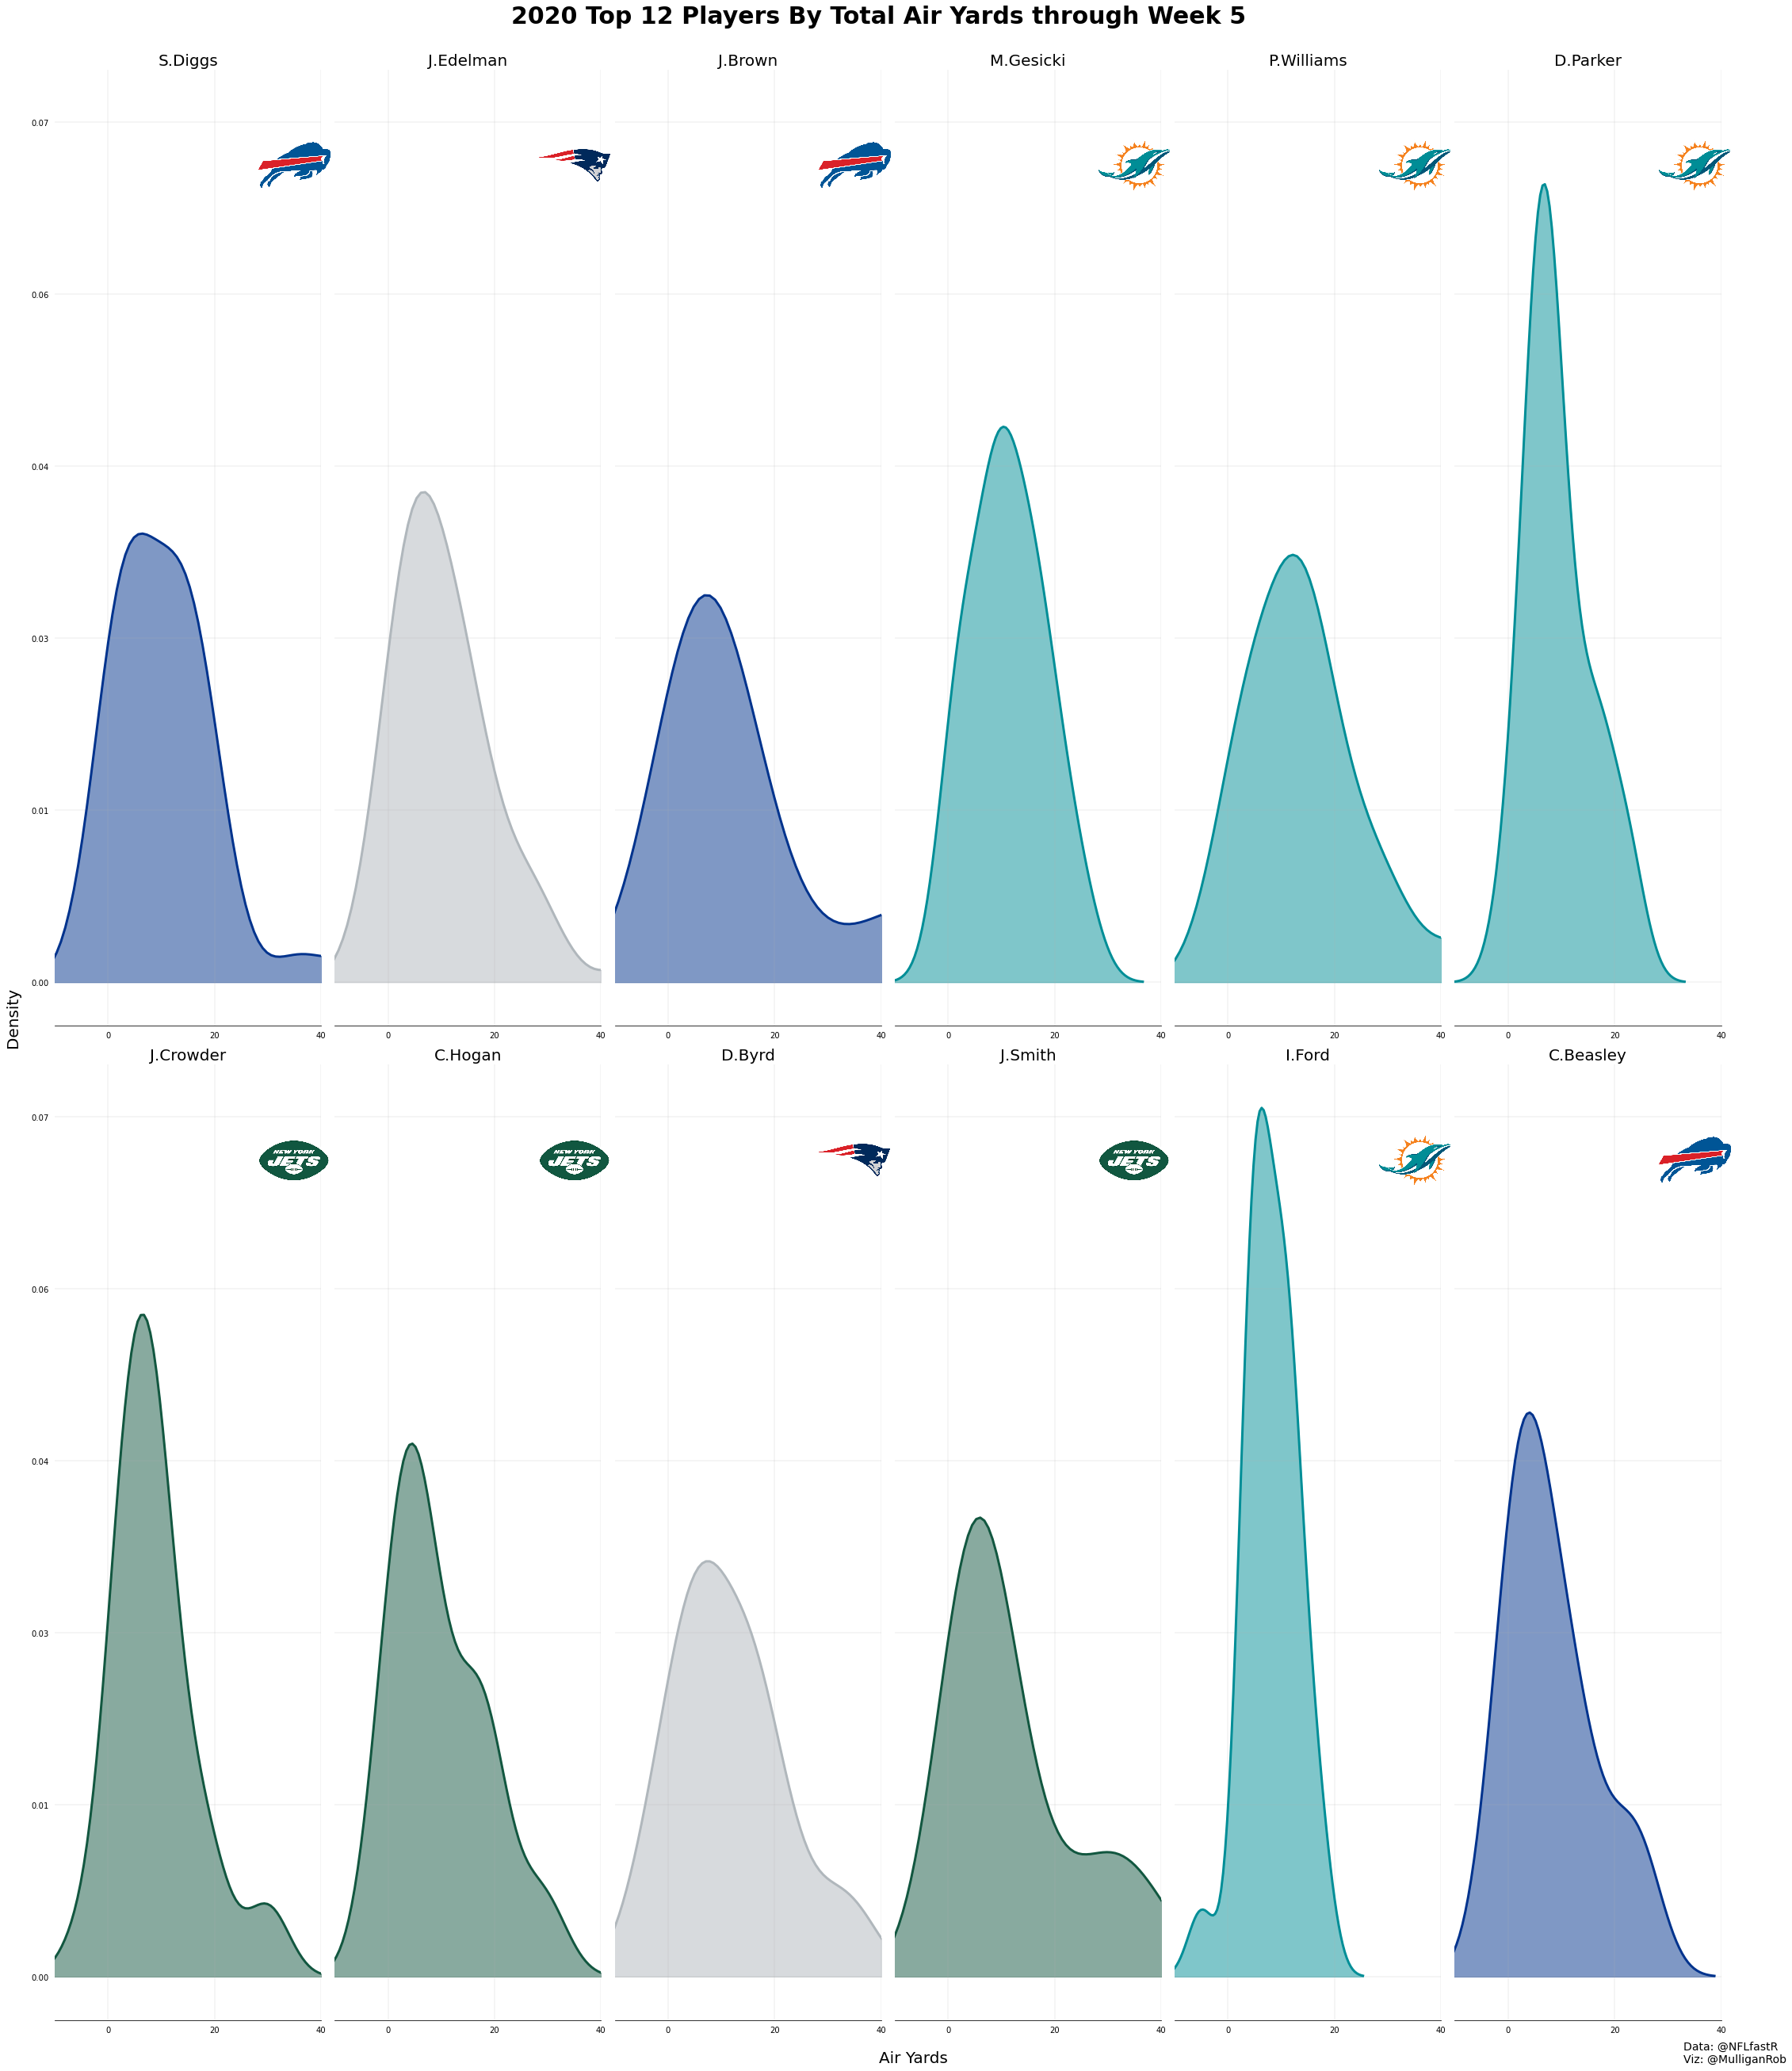

In [20]:
#density of AFC East air_yards
nflfastr.air_yard_density_viz(df1, 'NYJ', 'BUF', 'NE', 'MIA')